# Zero DCE for LoL Image Enhancement

In [ ]:
!pip install -qU wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 35.3 MB/s eta 0:00:00


In [ ]:
import wandb
from wandb.integration.keras import WandbCallback

In [ ]:
import os
import random
import numpy as np
from glob import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# download LoL dataset

run = wandb.init()
artifact = run.use_artifact('ivangoncharov/Low Light Enhancement with Zero-DCE/Lol_Dataset:v0', type='dataset')
artifact_dir = artifact.download()
artifact_path = os.path.join(artifact_dir, "lol_dataset.zip")
!unzip -o $artifact_path

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ryunuriadi (ryunuriadi-bina-nusantara) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact Lol_Dataset:v0, 331.09MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:6.1 (54.7MB/s)


Archive:  /content/artifacts/Lol_Dataset:v0/lol_dataset.zip
   creating: lol_dataset/
   creating: lol_dataset/eval15/
   creating: lol_dataset/eval15/high/
  inflating: lol_dataset/eval15/high/748.png  
  inflating: lol_dataset/eval15/high/665.png  
  inflating: lol_dataset/eval15/high/111.png  
  inflating: lol_dataset/eval15/high/493.png  
  inflating: lol_dataset/eval15/high/22.png  
  inflating: lol_dataset/eval15/high/23.png  
  inflating: lol_dataset/eval15/high/669.png  
  inflating: lol_dataset/eval15/high/547.png  
  inflating: lol_dataset/eval15/high/778.png  
  inflating: lol_dataset/eval15/high/55.png  
  inflating: lol_dataset/eval15/high/179.png  
  inflating: lol_dataset/eval15/high/780.png  
  inflating: lol_dataset/eval15/high/79.png  
  inflating: lol_dataset/eval15/high/146.png  
  inflating: lol_dataset/eval15/high/1.png  
  inflating: lol_dataset/eval15/.DS_Store  
   creating: lol_dataset/eval15/low/
  inflating: lol_dataset/eval15/low/748.png  
  inflating: lol_

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 4
MAX_TRAIN_IMAGES = 400

def load_data(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = image / 255.0
    return image

def data_generator(low_light_images):
    dataset = tf.data.Dataset.from_tensor_slices((low_light_images))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset

train_low_light_images = sorted(glob("./lol_dataset/our485/low/*"))[:MAX_TRAIN_IMAGES]
val_low_light_images = sorted(glob("./lol_dataset/our485/low/*"))[MAX_TRAIN_IMAGES:]
test_low_light_images = sorted(glob("./lol_dataset/eval15/low/*"))

train_dataset = data_generator(train_low_light_images)
val_dataset = data_generator(val_low_light_images)

In [ ]:
# get 100 train images

wandb.init(project="low_light_zero_DCE")

table = wandb.Table(columns=["Low light", "High light"])

for img_path in train_low_light_images[:100]:
  lowlight_image = Image.open(img_path)
  highlight_image = Image.open(img_path.replace("low", "high"))
  table.add_data(
        wandb.Image(np.array(lowlight_image)),
        wandb.Image(np.array(highlight_image)),
    )

wandb.log({"Dataset table": table})

wandb.finish()

In [ ]:
def build_dce_net():
    input_img = keras.Input(shape=[None, None, 3])
    conv1 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(input_img)
    conv2 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv1)
    conv3 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv2)
    conv4 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv3)
    int_con1 = layers.Concatenate(axis=-1)([conv4, conv3])
    conv5 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(int_con1)
    int_con2 = layers.Concatenate(axis=-1)([conv5, conv2])
    conv6 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(int_con2)
    int_con3 = layers.Concatenate(axis=-1)([conv6, conv1])
    x_r = layers.Conv2D(24, (3, 3), strides=(1, 1), activation="tanh", padding="same")(
        int_con3
    )
    return keras.Model(inputs=input_img, outputs=x_r)

In [ ]:
def color_constancy_loss(x):
    mean_rgb = tf.reduce_mean(x, axis=(1, 2), keepdims=True)
    mr, mg, mb = mean_rgb[:, :, :, 0], mean_rgb[:, :, :, 1], mean_rgb[:, :, :, 2]
    d_rg = tf.square(mr - mg)
    d_rb = tf.square(mr - mb)
    d_gb = tf.square(mb - mg)
    return tf.sqrt(tf.square(d_rg) + tf.square(d_rb) + tf.square(d_gb))

def exposure_loss(x, mean_val=0.6):
    x = tf.reduce_mean(x, axis=3, keepdims=True)
    mean = tf.nn.avg_pool2d(x, ksize=16, strides=16, padding="VALID")
    return tf.reduce_mean(tf.square(mean - mean_val))

def illumination_smoothness_loss(x):
    batch_size = tf.shape(x)[0]
    h_x = tf.shape(x)[1]
    w_x = tf.shape(x)[2]
    count_h = (tf.shape(x)[2] - 1) * tf.shape(x)[3]
    count_w = tf.shape(x)[2] * (tf.shape(x)[3] - 1)
    h_tv = tf.reduce_sum(tf.square((x[:, 1:, :, :] - x[:, : h_x - 1, :, :])))
    w_tv = tf.reduce_sum(tf.square((x[:, :, 1:, :] - x[:, :, : w_x - 1, :])))
    batch_size = tf.cast(batch_size, dtype=tf.float32)
    count_h = tf.cast(count_h, dtype=tf.float32)
    count_w = tf.cast(count_w, dtype=tf.float32)
    return 2 * (h_tv / count_h + w_tv / count_w) / batch_size

class SpatialConsistencyLoss(keras.losses.Loss):
    def __init__(self, **kwargs):
        super(SpatialConsistencyLoss, self).__init__(reduction="none")

        self.left_kernel = tf.constant(
            [[[[0, 0, 0]], [[-1, 1, 0]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.right_kernel = tf.constant(
            [[[[0, 0, 0]], [[0, 1, -1]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.up_kernel = tf.constant(
            [[[[0, -1, 0]], [[0, 1, 0]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.down_kernel = tf.constant(
            [[[[0, 0, 0]], [[0, 1, 0]], [[0, -1, 0]]]], dtype=tf.float32
        )

    def call(self, y_true, y_pred):

        original_mean = tf.reduce_mean(y_true, 3, keepdims=True)
        enhanced_mean = tf.reduce_mean(y_pred, 3, keepdims=True)
        original_pool = tf.nn.avg_pool2d(
            original_mean, ksize=4, strides=4, padding="VALID"
        )
        enhanced_pool = tf.nn.avg_pool2d(
            enhanced_mean, ksize=4, strides=4, padding="VALID"
        )

        d_original_left = tf.nn.conv2d(
            original_pool, self.left_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_original_right = tf.nn.conv2d(
            original_pool, self.right_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_original_up = tf.nn.conv2d(
            original_pool, self.up_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_original_down = tf.nn.conv2d(
            original_pool, self.down_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )

        d_enhanced_left = tf.nn.conv2d(
            enhanced_pool, self.left_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_enhanced_right = tf.nn.conv2d(
            enhanced_pool, self.right_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_enhanced_up = tf.nn.conv2d(
            enhanced_pool, self.up_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_enhanced_down = tf.nn.conv2d(
            enhanced_pool, self.down_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )

        d_left = tf.square(d_original_left - d_enhanced_left)
        d_right = tf.square(d_original_right - d_enhanced_right)
        d_up = tf.square(d_original_up - d_enhanced_up)
        d_down = tf.square(d_original_down - d_enhanced_down)
        return d_left + d_right + d_up + d_down

In [ ]:
# zero dce model

class ZeroDCE(keras.Model):
    def __init__(self, **kwargs):
        super(ZeroDCE, self).__init__(**kwargs)
        self.dce_model = build_dce_net()

    def compile(self, learning_rate, **kwargs):
        super(ZeroDCE, self).compile(**kwargs)
        self.optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        self.spatial_constancy_loss = SpatialConsistencyLoss(reduction="none")

    def get_enhanced_image(self, data, output):
        r1 = output[:, :, :, :3]
        r2 = output[:, :, :, 3:6]
        r3 = output[:, :, :, 6:9]
        r4 = output[:, :, :, 9:12]
        r5 = output[:, :, :, 12:15]
        r6 = output[:, :, :, 15:18]
        r7 = output[:, :, :, 18:21]
        r8 = output[:, :, :, 21:24]
        x = data + r1 * (tf.square(data) - data)
        x = x + r2 * (tf.square(x) - x)
        x = x + r3 * (tf.square(x) - x)
        enhanced_image = x + r4 * (tf.square(x) - x)
        x = enhanced_image + r5 * (tf.square(enhanced_image) - enhanced_image)
        x = x + r6 * (tf.square(x) - x)
        x = x + r7 * (tf.square(x) - x)
        enhanced_image = x + r8 * (tf.square(x) - x)
        return enhanced_image

    def call(self, data):
        dce_net_output = self.dce_model(data)
        return self.get_enhanced_image(data, dce_net_output)

    def compute_losses(self, data, output):
        enhanced_image = self.get_enhanced_image(data, output)
        loss_illumination = 200 * illumination_smoothness_loss(output)
        loss_spatial_constancy = tf.reduce_mean(
            self.spatial_constancy_loss(enhanced_image, data)
        )
        loss_color_constancy = 5 * tf.reduce_mean(color_constancy_loss(enhanced_image))
        loss_exposure = 10 * tf.reduce_mean(exposure_loss(enhanced_image))
        total_loss = (
            loss_illumination
            + loss_spatial_constancy
            + loss_color_constancy
            + loss_exposure
        )
        return {
            "total_loss": total_loss,
            "illumination_smoothness_loss": loss_illumination,
            "spatial_constancy_loss": loss_spatial_constancy,
            "color_constancy_loss": loss_color_constancy,
            "exposure_loss": loss_exposure,
        }

    def train_step(self, data):
        with tf.GradientTape() as tape:
            output = self.dce_model(data)
            losses = self.compute_losses(data, output)
        gradients = tape.gradient(
            losses["total_loss"], self.dce_model.trainable_weights
        )
        self.optimizer.apply_gradients(zip(gradients, self.dce_model.trainable_weights))
        return losses

    def test_step(self, data):
        output = self.dce_model(data)
        return self.compute_losses(data, output)

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        self.dce_model.save_weights(
            filepath, overwrite=overwrite, save_format=save_format, options=options
        )

    def load_weights(self, filepath, by_name=False, skip_mismatch=False, options=None):
        self.dce_model.load_weights(
            filepath=filepath,
            by_name=by_name,
            skip_mismatch=skip_mismatch,
            options=options,
        )

# Training

In [ ]:
wandb.init(project="low_light_zero_DCE", job_type="training")

In [ ]:
wandb.config.learning_rate = 1e-4

In [ ]:
zero_dce_model = ZeroDCE()
zero_dce_model.compile(learning_rate=wandb.config.learning_rate)
history = zero_dce_model.fit(train_dataset, validation_data=val_dataset, epochs=50, callbacks=[WandbCallback()])

wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.
wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 71ms/step - color_constancy_loss: 0.0031 - exposure_loss: 2.9249 - illumination_smoothness_loss: 1.6222 - spatial_constancy_loss: 5.1070e-05 - total_loss: 4.5503 - val_color_constancy_loss: 2.6370e-04 - val_exposure_loss: 3.1225 - val_illumination_smoothness_loss: 0.4808 - val_spatial_constancy_loss: 3.9605e-05 - val_total_loss: 3.6036
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - color_constancy_loss: 0.0032 - exposure_loss: 2.8632 - illumination_smoothness_loss: 0.6227 - spatial_constancy_loss: 2.4729e-04 - total_loss: 3.4894 - val_color_constancy_loss: 3.3309e-04 - val_exposure_loss: 3.0847 - val_illumination_smoothness_loss: 0.2503 - val_spatial_constancy_loss: 1.3639e-04 - val_total_loss: 3.3355
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - color_constancy_loss: 0.0037 - exposure_loss: 2.8082 - illumination_smoothness_loss: 0.3606 - spatial_constancy_loss: 5.8489e-04 - total_loss: 3.1731 - val_color_constancy_loss: 4.0

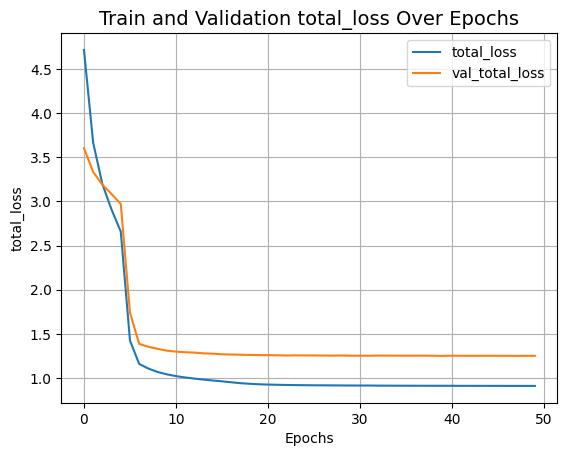

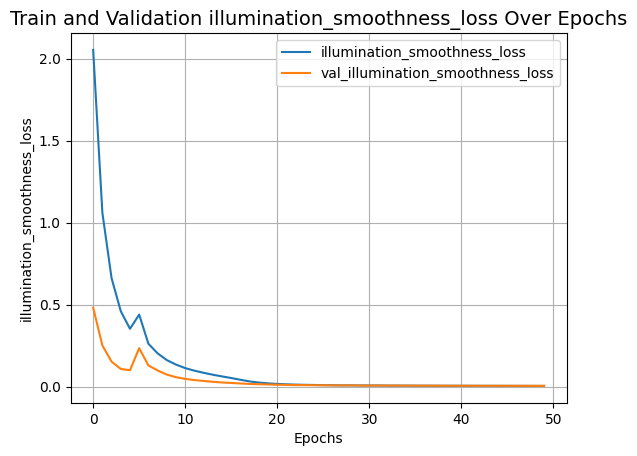

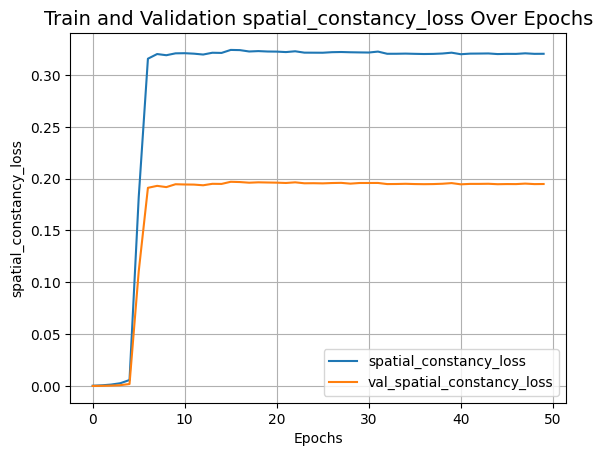

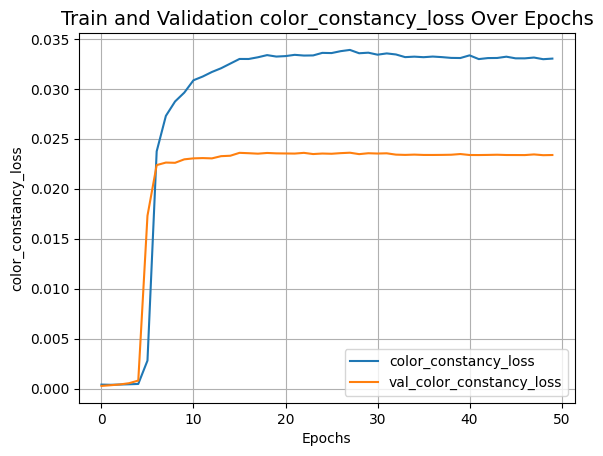

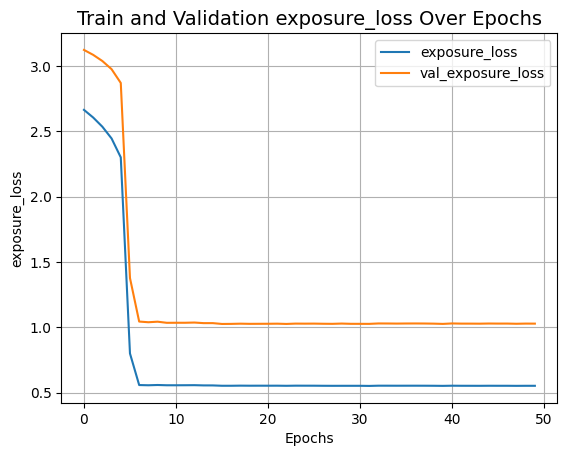

In [ ]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

plot_result("total_loss")
plot_result("illumination_smoothness_loss")
plot_result("spatial_constancy_loss")
plot_result("color_constancy_loss")
plot_result("exposure_loss")

# Inference on test images and visualize results using W&B Tables

In [ ]:
def plot_results(images, titles, figure_size=(12, 12)):
    fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i + 1).set_title(titles[i])
        _ = plt.imshow(images[i])
        plt.axis("off")
    plt.show()


def infer(original_image):
    image = keras.preprocessing.image.img_to_array(original_image)
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    output_image = zero_dce_model(image)
    output_image = tf.cast((output_image[0, :, :, :] * 255), dtype=np.uint8)
    output_image = Image.fromarray(output_image.numpy())
    return output_image

wandb.init(project="low_light_zero_DCE", job_type="predictions")

table = wandb.Table(columns=["Original", "PIL Autocontrast", "Enhanced"])
for val_image_file in test_low_light_images:
    original_image = Image.open(val_image_file)
    enhanced_image = infer(original_image)
    table.add_data(
        wandb.Image(np.array(original_image)),
        wandb.Image(np.array(ImageOps.autocontrast(original_image))),
        wandb.Image(np.array(enhanced_image))
    )

wandb.log({"Inference Table": table})

wandb.finish()

color_constancy_loss,▁▁▁▁▁▆▇▇▇▇██████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
exposure_loss,███▇▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
illumination_smoothness_loss,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
spatial_constancy_loss,▁▁▁▁▅███████████████████████████████████
total_loss,█▆▅▅▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_color_constancy_loss,▁▁▁▆████████████████████████████████████
val_exposure_loss,███▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_illumination_smoothness_loss,█▅▃▃▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_spatial_constancy_loss,▁▁▁▁▁███████████████████████████████████
val_total_loss,█▇▇▆▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [ ]:

sweep_config = {
    'method': 'random',
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    },
    'parameters': {
        'learning_rate': {
            'values': [1e-3, 1e-4, 5e-4]
        },
        'batch_size': {
            'values': [8, 16, 32]
        },
        'epochs': {
            'values': [10, 20]
        }
    }
}

import wandb
sweep_id = wandb.sweep(sweep_config, project='Low_Light_Image_Enhancement_Tuning')


Create sweep with ID: ep2unrpq
Sweep URL: https://wandb.ai/ryunuriadi-bina-nusantara/Low_Light_Image_Enhancement_Tuning/sweeps/ep2unrpq


In [ ]:
import os
import torch
import wandb
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image

# Define your model here (placeholder)
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 3, 3, padding=1)
        )

    def forward(self, x):
        return self.net(x)

# Dataset class
class LowLightDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        assert os.path.exists(image_dir), f"Directory does not exist: {image_dir}"
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, image  # for autoencoder: input == target

# Main training function
def train():
    wandb.init()
    config = wandb.config

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

    # Set correct paths
    train_dataset = LowLightDataset(image_dir='/content/dataset/train', transform=transform)
    val_dataset = LowLightDataset(image_dir='/content/dataset/val', transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

    model = SimpleCNN().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

    for epoch in range(config.epochs):
        model.train()
        total_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        wandb.log({"train_loss": avg_loss, "epoch": epoch + 1})

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        wandb.log({"val_loss": avg_val_loss})

        print(f"Epoch [{epoch+1}/{config.epochs}] Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Save sample output
        if epoch % 5 == 0:
            save_image(outputs[:4], f"output_epoch_{epoch+1}.png")
            wandb.save(f"output_epoch_{epoch+1}.png")


In [ ]:
# Source from cell with id: "O4zRhecfYDGr"
import os
import shutil
from glob import glob

# Ensure critical variables from cell 6 (execution_count: 27) are defined or re-defined.
# This makes the cell more robust if run independently or if agent context is tricky.
if 'MAX_TRAIN_IMAGES' not in globals():
    MAX_TRAIN_IMAGES = 400 # This was defined in cell 6
if 'train_low_light_images' not in globals() or 'val_low_light_images' not in globals():
    print("train_low_light_images or val_low_light_images not in globals. Redefining them.")
    # These paths assume the current working directory is /content/, which is typical for Colab.
    # The lol_dataset was unzipped here by cell 5.
    train_low_light_images = sorted(glob("./lol_dataset/our485/low/*"))[:MAX_TRAIN_IMAGES]
    val_low_light_images = sorted(glob("./lol_dataset/our485/low/*"))[MAX_TRAIN_IMAGES:]

target_train_dir = '/content/dataset/train'
target_val_dir = '/content/dataset/val'

os.makedirs(target_train_dir, exist_ok=True)
os.makedirs(target_val_dir, exist_ok=True)

print(f"Populating {target_train_dir} with {len(train_low_light_images)} images...")
for img_path in train_low_light_images:
    shutil.copy(img_path, target_train_dir)

print(f"Populating {target_val_dir} with {len(val_low_light_images)} images...")
for img_path in val_low_light_images:
    shutil.copy(img_path, target_val_dir)

print("Dataset directories populated for PyTorch sweep.")

# Optional: Verify a few files exist to confirm population
if os.path.exists(target_train_dir) and os.listdir(target_train_dir):
    print(f"First 5 files in {target_train_dir}: {os.listdir(target_train_dir)[:5]}")
if os.path.exists(target_val_dir) and os.listdir(target_val_dir):
    print(f"First 5 files in {target_val_dir}: {os.listdir(target_val_dir)[:5]}")

Populating /content/dataset/train with 400 images...
Populating /content/dataset/val with 85 images...
Dataset directories populated for PyTorch sweep.
First 5 files in /content/dataset/train: ['162.png', '257.png', '67.png', '592.png', '682.png']
First 5 files in /content/dataset/val: ['87.png', '765.png', '80.png', '737.png', '729.png']


In [ ]:
wandb.agent(sweep_id, function=train, count=10)

wandb: Agent Starting Run: vvb7pmuy with config:
wandb: 	batch_size: 8
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001


Epoch [1/20] Train Loss: 0.0026, Val Loss: 0.0010
Epoch [2/20] Train Loss: 0.0007, Val Loss: 0.0004
Epoch [3/20] Train Loss: 0.0004, Val Loss: 0.0003
Epoch [4/20] Train Loss: 0.0003, Val Loss: 0.0003
Epoch [5/20] Train Loss: 0.0003, Val Loss: 0.0002
Epoch [6/20] Train Loss: 0.0002, Val Loss: 0.0002
Epoch [7/20] Train Loss: 0.0002, Val Loss: 0.0002
Epoch [8/20] Train Loss: 0.0001, Val Loss: 0.0002
Epoch [9/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [10/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [11/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [12/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [13/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [14/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [15/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [16/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [17/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [18/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [19/20] Train Loss: 0.0000, Val Loss: 0.0001
Epoch [20/20] Train Loss: 0.0000, Val Lo

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,20
train_loss,4e-05
val_loss,5e-05


wandb: Agent Starting Run: b3im8ndn with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001


Epoch [1/20] Train Loss: 0.0046, Val Loss: 0.0030
Epoch [2/20] Train Loss: 0.0033, Val Loss: 0.0022
Epoch [3/20] Train Loss: 0.0025, Val Loss: 0.0016
Epoch [4/20] Train Loss: 0.0017, Val Loss: 0.0011
Epoch [5/20] Train Loss: 0.0012, Val Loss: 0.0008
Epoch [6/20] Train Loss: 0.0008, Val Loss: 0.0005
Epoch [7/20] Train Loss: 0.0005, Val Loss: 0.0004
Epoch [8/20] Train Loss: 0.0004, Val Loss: 0.0004
Epoch [9/20] Train Loss: 0.0004, Val Loss: 0.0003
Epoch [10/20] Train Loss: 0.0003, Val Loss: 0.0003
Epoch [11/20] Train Loss: 0.0003, Val Loss: 0.0003
Epoch [12/20] Train Loss: 0.0003, Val Loss: 0.0003
Epoch [13/20] Train Loss: 0.0003, Val Loss: 0.0003
Epoch [14/20] Train Loss: 0.0002, Val Loss: 0.0002
Epoch [15/20] Train Loss: 0.0002, Val Loss: 0.0002
Epoch [16/20] Train Loss: 0.0002, Val Loss: 0.0002
Epoch [17/20] Train Loss: 0.0002, Val Loss: 0.0002
Epoch [18/20] Train Loss: 0.0002, Val Loss: 0.0002
Epoch [19/20] Train Loss: 0.0002, Val Loss: 0.0002
Epoch [20/20] Train Loss: 0.0002, Val Lo

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▆▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
train_loss,0.00016
val_loss,0.00017


wandb: Agent Starting Run: uhvrhekr with config:
wandb: 	batch_size: 8
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0005


Epoch [1/20] Train Loss: 0.0013, Val Loss: 0.0002
Epoch [2/20] Train Loss: 0.0001, Val Loss: 0.0002
Epoch [3/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [4/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [5/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [6/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [7/20] Train Loss: 0.0000, Val Loss: 0.0000
Epoch [8/20] Train Loss: 0.0000, Val Loss: 0.0000
Epoch [9/20] Train Loss: 0.0000, Val Loss: 0.0000
Epoch [10/20] Train Loss: 0.0000, Val Loss: 0.0000
Epoch [11/20] Train Loss: 0.0000, Val Loss: 0.0000
Epoch [12/20] Train Loss: 0.0000, Val Loss: 0.0000
Epoch [13/20] Train Loss: 0.0000, Val Loss: 0.0000
Epoch [14/20] Train Loss: 0.0000, Val Loss: 0.0000
Epoch [15/20] Train Loss: 0.0000, Val Loss: 0.0000
Epoch [16/20] Train Loss: 0.0000, Val Loss: 0.0000
Epoch [17/20] Train Loss: 0.0000, Val Loss: 0.0000
Epoch [18/20] Train Loss: 0.0000, Val Loss: 0.0000
Epoch [19/20] Train Loss: 0.0000, Val Loss: 0.0000
Epoch [20/20] Train Loss: 0.0000, Val Lo

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch,20
train_loss,1e-05
val_loss,1e-05


wandb: Agent Starting Run: opzxaand with config:
wandb: 	batch_size: 8
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0005


Epoch [1/10] Train Loss: 0.0015, Val Loss: 0.0002
Epoch [2/10] Train Loss: 0.0002, Val Loss: 0.0001
Epoch [3/10] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [4/10] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [5/10] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [6/10] Train Loss: 0.0000, Val Loss: 0.0000
Epoch [7/10] Train Loss: 0.0000, Val Loss: 0.0000
Epoch [8/10] Train Loss: 0.0000, Val Loss: 0.0000
Epoch [9/10] Train Loss: 0.0000, Val Loss: 0.0000
Epoch [10/10] Train Loss: 0.0000, Val Loss: 0.0000


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▂▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
train_loss,2e-05
val_loss,2e-05


wandb: Agent Starting Run: spdmgeqm with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0005


Epoch [1/10] Train Loss: 0.0016, Val Loss: 0.0003
Epoch [2/10] Train Loss: 0.0004, Val Loss: 0.0002
Epoch [3/10] Train Loss: 0.0002, Val Loss: 0.0002
Epoch [4/10] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [5/10] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [6/10] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [7/10] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [8/10] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [9/10] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [10/10] Train Loss: 0.0000, Val Loss: 0.0001


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▂▂▁▁▁▁▁▁▁
val_loss,█▇▅▃▃▂▂▂▁▁
epoch,10
train_loss,5e-05
val_loss,6e-05


wandb: Agent Starting Run: 9fo8equ5 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001


Epoch [1/20] Train Loss: 0.0031, Val Loss: 0.0009
Epoch [2/20] Train Loss: 0.0007, Val Loss: 0.0004
Epoch [3/20] Train Loss: 0.0003, Val Loss: 0.0003
Epoch [4/20] Train Loss: 0.0002, Val Loss: 0.0002
Epoch [5/20] Train Loss: 0.0002, Val Loss: 0.0002
Epoch [6/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [7/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [8/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [9/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [10/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [11/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [12/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [13/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [14/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [15/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [16/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [17/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [18/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [19/20] Train Loss: 0.0000, Val Loss: 0.0001
Epoch [20/20] Train Loss: 0.0000, Val Lo

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
train_loss,5e-05
val_loss,5e-05


wandb: Agent Starting Run: nmt6tq71 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001


Epoch [1/20] Train Loss: 0.0037, Val Loss: 0.0005
Epoch [2/20] Train Loss: 0.0005, Val Loss: 0.0004
Epoch [3/20] Train Loss: 0.0003, Val Loss: 0.0002
Epoch [4/20] Train Loss: 0.0002, Val Loss: 0.0002
Epoch [5/20] Train Loss: 0.0001, Val Loss: 0.0002
Epoch [6/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [7/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [8/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [9/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [10/20] Train Loss: 0.0000, Val Loss: 0.0001
Epoch [11/20] Train Loss: 0.0000, Val Loss: 0.0001
Epoch [12/20] Train Loss: 0.0000, Val Loss: 0.0000
Epoch [13/20] Train Loss: 0.0000, Val Loss: 0.0000
Epoch [14/20] Train Loss: 0.0000, Val Loss: 0.0000
Epoch [15/20] Train Loss: 0.0000, Val Loss: 0.0000
Epoch [16/20] Train Loss: 0.0000, Val Loss: 0.0000
Epoch [17/20] Train Loss: 0.0000, Val Loss: 0.0000
Epoch [18/20] Train Loss: 0.0000, Val Loss: 0.0000
Epoch [19/20] Train Loss: 0.0000, Val Loss: 0.0000
Epoch [20/20] Train Loss: 0.0000, Val Lo

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch,20
train_loss,2e-05
val_loss,2e-05


wandb: Agent Starting Run: v4sdji0c with config:
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001


Epoch [1/20] Train Loss: 0.0037, Val Loss: 0.0025
Epoch [2/20] Train Loss: 0.0023, Val Loss: 0.0016
Epoch [3/20] Train Loss: 0.0013, Val Loss: 0.0009
Epoch [4/20] Train Loss: 0.0007, Val Loss: 0.0005
Epoch [5/20] Train Loss: 0.0004, Val Loss: 0.0004
Epoch [6/20] Train Loss: 0.0003, Val Loss: 0.0003
Epoch [7/20] Train Loss: 0.0003, Val Loss: 0.0003
Epoch [8/20] Train Loss: 0.0002, Val Loss: 0.0002
Epoch [9/20] Train Loss: 0.0002, Val Loss: 0.0002
Epoch [10/20] Train Loss: 0.0002, Val Loss: 0.0002
Epoch [11/20] Train Loss: 0.0002, Val Loss: 0.0002
Epoch [12/20] Train Loss: 0.0001, Val Loss: 0.0002
Epoch [13/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [14/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [15/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [16/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [17/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [18/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [19/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [20/20] Train Loss: 0.0001, Val Lo

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
train_loss,7e-05
val_loss,8e-05


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dai06yo8 with config:
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001


Epoch [1/20] Train Loss: 0.0026, Val Loss: 0.0005
Epoch [2/20] Train Loss: 0.0004, Val Loss: 0.0002
Epoch [3/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [4/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [5/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [6/20] Train Loss: 0.0001, Val Loss: 0.0001
Epoch [7/20] Train Loss: 0.0000, Val Loss: 0.0001
Epoch [8/20] Train Loss: 0.0000, Val Loss: 0.0000
Epoch [9/20] Train Loss: 0.0000, Val Loss: 0.0000
Epoch [10/20] Train Loss: 0.0000, Val Loss: 0.0000
Epoch [11/20] Train Loss: 0.0000, Val Loss: 0.0000
Epoch [12/20] Train Loss: 0.0000, Val Loss: 0.0000
Epoch [13/20] Train Loss: 0.0000, Val Loss: 0.0000
Epoch [14/20] Train Loss: 0.0000, Val Loss: 0.0000
Epoch [15/20] Train Loss: 0.0000, Val Loss: 0.0000
Epoch [16/20] Train Loss: 0.0000, Val Loss: 0.0000
Epoch [17/20] Train Loss: 0.0000, Val Loss: 0.0000
Epoch [18/20] Train Loss: 0.0000, Val Loss: 0.0000
Epoch [19/20] Train Loss: 0.0000, Val Loss: 0.0000
Epoch [20/20] Train Loss: 0.0000, Val Lo

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
train_loss,1e-05
val_loss,1e-05


wandb: Agent Starting Run: 0h857rzs with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001


Epoch [1/20] Train Loss: 0.0095, Val Loss: 0.0071
Epoch [2/20] Train Loss: 0.0069, Val Loss: 0.0051
Epoch [3/20] Train Loss: 0.0050, Val Loss: 0.0036
Epoch [4/20] Train Loss: 0.0035, Val Loss: 0.0026
Epoch [5/20] Train Loss: 0.0025, Val Loss: 0.0019
Epoch [6/20] Train Loss: 0.0018, Val Loss: 0.0014
Epoch [7/20] Train Loss: 0.0013, Val Loss: 0.0011
Epoch [8/20] Train Loss: 0.0010, Val Loss: 0.0008
Epoch [9/20] Train Loss: 0.0008, Val Loss: 0.0006
Epoch [10/20] Train Loss: 0.0006, Val Loss: 0.0005
Epoch [11/20] Train Loss: 0.0005, Val Loss: 0.0005
Epoch [12/20] Train Loss: 0.0005, Val Loss: 0.0004
Epoch [13/20] Train Loss: 0.0004, Val Loss: 0.0004
Epoch [14/20] Train Loss: 0.0004, Val Loss: 0.0003
Epoch [15/20] Train Loss: 0.0003, Val Loss: 0.0003
Epoch [16/20] Train Loss: 0.0003, Val Loss: 0.0003
Epoch [17/20] Train Loss: 0.0003, Val Loss: 0.0003
Epoch [18/20] Train Loss: 0.0002, Val Loss: 0.0002
Epoch [19/20] Train Loss: 0.0002, Val Loss: 0.0002
Epoch [20/20] Train Loss: 0.0002, Val Lo

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▆▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
train_loss,0.00022
val_loss,0.00021


In [ ]:
import wandb

# sweep_id should be defined in the previous cell (cell 37)
# For example, if your sweep_id was '3m7gbi9l'
# sweep_id = '3m7gbi9l'
# If sweep_id is not in globals (e.g. running this cell independently after kernel restart)
# you'll need to set it manually or re-run the cell that defines it.
if 'sweep_id' not in globals():
    print("sweep_id is not defined. Please define it or re-run the cell that creates the sweep.")
    # As a placeholder if you need to run this cell and the sweep_id was previously printed:
    # sweep_id = "YOUR_SWEEP_ID_HERE" # Replace with your actual sweep_id
else:
    print(f"Using sweep_id: {sweep_id}")

    # Initialize wandb API
    api = wandb.Api()

    # Get the sweep
    try:
        sweep = api.sweep(f"ryunuriadi-bina-nusantara/Low_Light_Image_Enhancement_Tuning/{sweep_id}") # Replace with your entity/project

        # Get all runs from the sweep, ordered by the metric (val_loss, minimized)
        # Note: sweep.best_run() might be simpler if you only need the single best run.
        # However, to ensure we get the one with the numerically lowest val_loss if multiple runs have the same best_value:
        runs = sorted(sweep.runs, key=lambda run: run.summary.get("val_loss", float('inf')))


        if runs:
            best_run = runs[0]  # The first run in the sorted list is the best
            print("\n--- Best Run ---")
            print(f"Run ID: {best_run.id}")
            print(f"Run Name: {best_run.name}")
            print(f"Validation Loss (val_loss): {best_run.summary.get('val_loss', 'N/A')}")
            print("\nBest Hyperparameters:")
            for key, value in best_run.config.items():
                # Wandb sometimes adds its own keys starting with '_'. We can ignore them.
                if not key.startswith("_"):
                    print(f"  {key}: {value}")

            # You can also print other summary metrics if available
            print("\nOther Summary Metrics for the Best Run:")
            for metric, value in best_run.summary.items():
                if metric not in ['val_loss', '_runtime', '_timestamp', '_step']: # Exclude some common ones
                     print(f"  {metric}: {value}")

        else:
            print("No runs found for this sweep yet, or the sweep did not complete successfully.")

    except Exception as e:
        print(f"An error occurred while fetching sweep data: {e}")
        print("Please ensure the sweep_id and project path (entity/project/sweep_id) are correct.")
        print("Also, make sure you are logged into wandb (wandb login).")

Using sweep_id: ep2unrpq

--- Best Run ---
Run ID: uhvrhekr
Run Name: good-sweep-3
Validation Loss (val_loss): 1.3390095690820916e-05

Best Hyperparameters:
  epochs: 20
  batch_size: 8
  learning_rate: 0.0005

Other Summary Metrics for the Best Run:
  _wandb: {'runtime': 122}
  epoch: 20
  train_loss: 1.1065689259339706e-05


In [ ]:
base_model = build_dce_net()

In [ ]:
base_model.save("base_model.h5")

In [ ]:
from google.colab import files
files.download("base_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model = load_model("base_model.h5", compile=False)

In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, None,      │        896 │ input_layer_2[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, None,      │      9,248 │ conv2d_14[0][0]   │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, None,      │      9,248 │ conv2d_15[0][0]   │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, None,      │      9,248 │ conv2d_16[0][0]   │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, None,      │          0 │ conv2d_17[0][0],  │
│ (Concatenate)       │ None, 64)         │            │ conv2d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, None,      │     18,464 │ concatenate_6[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, None,      │          0 │ conv2d_18[0][0],  │
│ (Concatenate)       │ None, 64)         │            │ conv2d_15[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, None,      │     18,464 │ concatenate_7[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, None,      │          0 │ conv2d_19[0][0],  │
│ (Concatenate)       │ None, 64)         │            │ conv2d_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, None,      │     13,848 │ concatenate_8[0]… │
│                     │ None, 24)         │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 79,416 (310.22 KB)

 Trainable params: 79,416 (310.22 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np
import cv2
from google.colab import files
import matplotlib.pyplot as plt
import os

# Load model
model = load_model("base_model.h5", compile=False)

In [ ]:
def load_image(filepath, target_size=None):
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if target_size:
        img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0
    return img

def save_image(img, filename):
    img = np.clip(img * 255.0, 0, 255).astype(np.uint8)
    cv2.imwrite(filename, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

def enhance_image(img, model, iterations=8):
    input_img = tf.convert_to_tensor(np.expand_dims(img, axis=0))
    A = model(input_img)[0]  # shape: (H, W, 24)

    R = tf.convert_to_tensor(img)
    R = tf.identity(R)
    for i in range(iterations):
        a = A[..., i*3:(i+1)*3]
        R = R + a * (tf.square(R) - R)
    return R.numpy()

In [ ]:
# Upload gambar dari lokal
uploaded = files.upload()

for filename in uploaded.keys():
    print(f"Memproses: {filename}")

    img = load_image(filename)
    enhanced = enhance_image(img, model)

    # Tampilkan sebelum/sesudah
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(enhanced)
    plt.title("Enhanced")
    plt.axis('off')
    plt.show()

    # Simpan hasil
    output_name = f"enhanced_{os.path.basename(filename)}"
    save_image(enhanced, output_name)
    files.download(output_name)

Saving IMG_7179.CR2 to IMG_7179.CR2
Memproses: IMG_7179.CR2


error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
from google.colab import files
files.download("base_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>